# Cleansing and Wrangling Data

We need to do some cleansing and wrangling task before start analysing the data. 

## Import Libraries and Set Options

In [1]:
import sqlite3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import collections

from daftpy.daftdata import get_db, db_dict, to_datetime, sale_dict_daily, drop_renewed, concatenate_dropping_renewed

from daftpy.daftprep import (num_perc, process_price, process_coordinates, drop_coord_outliers, drop_floor_area, 
                             floor_area_wragling, process_floor_area, drop_info, process_info, process_views, process_rooms)

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

## Load Data

We load the information through a fuction whict drops the advertiser's private information. 

In [3]:
sale = get_db(dbname='2021-11-25.db')

In [4]:
sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15391 entries, 0 to 15390
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   daft_id                       15391 non-null  object
 1   item_id                       15391 non-null  object
 2   url                           15391 non-null  object
 3   name                          15391 non-null  object
 4   price                         15391 non-null  object
 5   info                          15391 non-null  object
 6   sale_type                     15391 non-null  object
 7   floor_area                    15391 non-null  object
 8   psr                           15391 non-null  object
 9   ber                           15391 non-null  object
 10  entered_renewed               15391 non-null  object
 11  views                         15391 non-null  object
 12  type_house                    15391 non-null  object
 13  energy_performan

## Check Missing Values and Duplicates

In [5]:
sale.replace('none', np.nan, inplace=True)

# Check missing values in absolute and relative terms
pd.DataFrame({
    'Absolute': sale.isna().sum(), 
    'Relative': sale.isna().sum() / sale.shape[0]
             })

,Absolute,Relative
daft_id,0,0.000000
item_id,0,0.000000
url,0,0.000000
name,278,0.018063
price,278,0.018063
info,278,0.018063
sale_type,285,0.018517
floor_area,285,0.018517
psr,80,0.005198
ber,3742,0.243129


The feature `energy_performance_indicator` has too many missing values, thus we should beware of them.

|Feature|% missing values|
|:---:|:---:|
|energy_performance_indicator|62|

As it has such a high percentage of missing values and it doesn't appear to be a critical feature we can drop it.

We shouldn't have any duplicated listing thanks to the DuplicatesPipeline implemented in the Scrapy project.

In [6]:
sale.duplicated(keep=False).sum()

0

In [7]:
sale.sample()

,daft_id,item_id,url,name,price,info,sale_type,floor_area,psr,ber,entered_renewed,views,type_house,energy_performance_indicator,coordinates,type,scraping_date,description
1082,16088889,3516992,https://www.daft.ie/for-sale/apartment-apartme...,"Apartment 1, Waveney House, Howth, Dublin 13","€320,000","1 Bed,1 Bath,55 m²,Apartment",For Sale by Private Treaty,55 m²,001012,D1,22/11/2021,"8,154",apartment,240.26 kWh/m2/yr,53.388233+-6.071194,buy,2021-11-25,Mc Peake Auctioneers are delighted to introduc...


Next, let's start the cleansing and wrangling tasks.

## Psr and Energy Performance Indicator

We start dropping both columns as we concluded above.

In [8]:
print(f'Before dropping: {sale.shape}')
sale.drop(columns=['energy_performance_indicator'], inplace=True)
print(f'After dropping: {sale.shape}')

Before dropping: (15391, 18)
After dropping: (15391, 17)


## Price

We have strange data points in the column. Let's investigate the different structures we can see:

In [9]:
#sale['price'].value_counts()

In [10]:
# The following are the diferent data point extructures that we can see in 
# the `price` column
sale['price'][[0, 8, 13, 28, 1442, 12842]]

0                         €549,000
8                    AMV: €725,000
13                             NaN
28            Price on Application
1442     AMV: Price on Application
12842          £149,000 (€173,554)
Name: price, dtype: object

**1. Price on Application**

`Price on Application` is the most repeated value in the `price` column. It equates to a 7.63% of ads.

In [11]:
# Ads with `Price on Application` pattern
num_perc(df=sale, 
         feature='price', 
         pattern='Price on Application')

Ads with "Price on Application": 1174
Ads with "Price on Application": 7.63%


,daft_id,item_id,url,name,price,info,sale_type,floor_area,psr,ber,entered_renewed,views,type_house,coordinates,type,scraping_date,description
3687,16823432,3604100,https://www.daft.ie/for-sale/apartment-2-meado...,"2 Meadow Court, Elm Park, Claremorris, Co. Mayo",Price on Application,"2 Bed,2 Bath,70 m²,Apartment",For Sale by Private Treaty,70 m²,002305,C3,05/11/2021,958,apartment,53.727685+-8.996586,buy,2021-11-25,No.2 Meadow Court is a two bedroom ground floo...


We will drop this kind of ads because we can't find out their prices.

**2. AMV: Price on Application**

In [12]:
# Ads with `AMV: Price on Application` pattern
num_perc(df=sale, 
         feature='price', 
         pattern='AMV: Price on Application')

Ads with "AMV: Price on Application": 8
Ads with "AMV: Price on Application": 0.05%


,daft_id,item_id,url,name,price,info,sale_type,floor_area,psr,ber,entered_renewed,views,type_house,coordinates,type,scraping_date,description
11133,15531906,3441506,https://www.daft.ie/for-sale/detached-house-as...,"Askinamoe, Ferns, Enniscorthy, Co. Wexford",AMV: Price on Application,"1 Bed,Detached",For Sale by Public Auction,ON-LINE,002020,SI_666,24/11/2021,"4,118",house,52.6068023705902+-6.518592035977434,buy,2021-11-25,Property Ref: P4986\r\n \r\nValuable C. 7.2 Ac...


We will drop this kind of ads because we can't find out their prices.

**3. AMV: €725,000**

This patron is repeated a lot of times in the column, we will have to apply wrangling task on them.

**4. NaN**

In [13]:
# Ads with missing values
num_perc(df=sale, 
         feature='price', 
         pattern=np.nan)

Ads with "nan": 278
Ads with "nan": 1.81%


,daft_id,item_id,url,name,price,info,sale_type,floor_area,psr,ber,entered_renewed,views,type_house,coordinates,type,scraping_date,description
642,93322334,2841491,https://www.daft.ie/new-home-for-sale/gallowhi...,NaN,NaN,NaN,NaN,NaN,001382,NA,19/10/2021,"8,539",NaN,52.99672004705863+-6.962314621711755,buy,2021-11-25,** August launch of 3 Bedroom Semi-detached ho...


Advertisements with missing values in the `price` column are 'Development' ads, not 'Houses' ads. Development ads have several houses in it and that is why they have missing values. Furthermore, the houses belonging to developments are already scraped so we should drop the development ads.

In [14]:
# You can check the above statement with the lines of code bellow

# sale[sale['price'].isna()] # Commented for sthetic reasons
sale.loc[sale['price'].isna(), 'url'].sample().values # url to check the ad

array(['https://www.daft.ie/new-home-for-sale/elmbury-carrigane-carrigtwohill-co-cork/2328473'],
      dtype=object)

**5. £149,000 (€173,554)**

In [15]:
# Ads with '£' pattern
num_perc(df=sale, 
         feature='price', 
         pattern='£')

Ads with "£": 25
Ads with "£": 0.16%


,daft_id,item_id,url,name,price,info,sale_type,floor_area,psr,ber,entered_renewed,views,type_house,coordinates,type,scraping_date,description
2895,16900398,3611134,https://www.daft.ie/for-sale/terraced-house-60...,"60 Shore Road, Belfast City Centre, Co. Antrim","£77,500 (€90,272)","4 Bed,1 Bath,Terrace",For Sale by Private Treaty,For Sale by Private Treaty,002978,NaN,12/11/2021,"1,274",house,54.6239209+-5.9231668,buy,2021-11-25,McMillan Estate Agents in partnership with NI ...


Ads with prices in pounds are usually from North Ireland, which belongs to United Kingdom so we will drop these ads.

In [16]:
# You can check the above statement with the lines of code bellow

# sale.dropna(subset=['price']).loc[
 #    sale.dropna(subset=['price'])['price'].str.contains('£')] # Commented for sthetic reasons

sale.dropna(subset=['price']).loc[
    sale.dropna(subset=['price'])['price'].str.contains('£'), 'url'
                                 ].sample().values # url to check the ad

array(['https://www.daft.ie/for-sale/terraced-house-46-windsor-avenue-whitehead-carrickfergus-co-antrim/3576092'],
      dtype=object)

**-> Conclusion**

Wrangling and cleansing tasks: 

|Value structure in ad's price|Number of ads|Percentage of ads|Task|
|:---:|:---:|:---:|:---:|
|€549,000|||Wrangling|
|AMV: €725,000|||Wrangling|
|£149,000 (€173,554)|25|0.16%|Drop|
|Price on Application|1174|7.63%|Drop|
|AMV: Price on Application|8|0.05%|Drop|
|NaN|278|1.81%|Drop|

Let's compare the before and after of transformations.

In [17]:
pd.DataFrame({'before': sale['price'], 
              'after': process_price(sale)['price']}).head(10)

Rows before dropping: 15391
Rows after dropping: 13906
----------
Difference: -1485


,before,after
0,"€549,000",549000.0
1,"€220,000",220000.0
2,"€495,000",495000.0
3,"€350,000",350000.0
4,"€450,000",450000.0
5,"€365,000",365000.0
6,"€325,000",325000.0
7,"€550,000",550000.0
8,"AMV: €725,000",725000.0
9,"€325,000",325000.0


Let's do it!

In [19]:
sale = process_price(sale.copy()).reset_index(drop=True)

Rows before dropping: 15391
Rows after dropping: 13906
----------
Difference: -1485


## Coordinates

In [13]:
sale_data['coordinates'].sample()

9029    51.885624+-8.566972
Name: coordinates, dtype: object

In [14]:
sale_data = process_coordinates(sale_data)

(14832, 17)
(14832, 18)


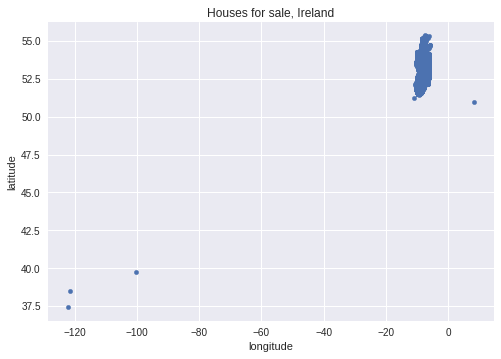

In [15]:
sale_data.plot(kind='scatter', x='longitude', y='latitude', title='Houses for sale, Ireland');

In [16]:
sale_data = drop_coord_outliers(sale_data)

(14832, 18)
(14823, 18)


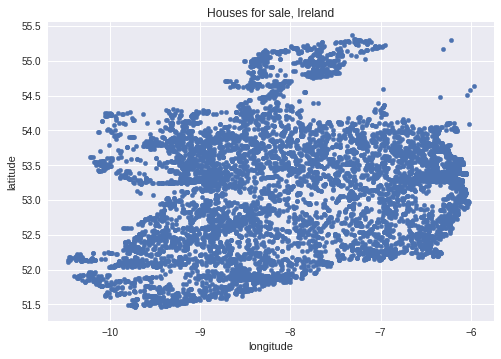

In [17]:
sale_data.plot(kind='scatter', x='longitude', y='latitude', title='Houses for sale, Ireland'); # esta un poco achatada pero es Irlanda

## Floor Area

In [18]:
sale_data['floor_area'].sample(30)

14204                        756 m²
5113                           2 ac
9182                          60 m²
7024                          68 m²
8713                         210 m²
2426     For Sale by Private Treaty
7438                         157 m²
9189                        0.63 ac
9738                         149 m²
13601                         58 m²
6476     For Sale by Private Treaty
6700                         126 m²
13097    For Sale by Private Treaty
10942                        116 m²
5979                         111 m²
7771                         127 m²
1498                         125 m²
10944                       0.75 ac
14649                       0.55 ac
12369    For Sale by Private Treaty
3993                          91 m²
3426                         118 m²
10928    For Sale by Private Treaty
12622                        256 m²
11375                         87 m²
2516                         1.3 ac
1000                          90 m²
13897                       

In [19]:
sale_data['floor_area'].str.contains('m²').sum()

8356

In [20]:
sale_data.shape[0] - sale_data['floor_area'].str.contains('m²').sum() #---> Drop 6467 assets
# Estudiar los precios medios, etc, de las casas eliminadas para ver si son similares a los que tienen m²

6467

In [21]:
sale_data['floor_area'].str.contains('m²').head(3)

0     True
1     True
2    False
Name: floor_area, dtype: object

In [22]:
sale_data['floor_area'].str.contains('m²').head(3) == False

0    False
1    False
2     True
Name: floor_area, dtype: bool

In [23]:
index_to_drop = sale_data[sale_data['floor_area'].str.contains('m²') == False].index
len(index_to_drop) # esta diferenci de 8 se debe a missing values

6174

In [24]:
#, inplace=True
sale_data.drop(index=index_to_drop)['floor_area'].isna().sum()

293

In [25]:
sale_data.drop(index=index_to_drop).loc[sale_data.drop(index=index_to_drop)['floor_area'].isna(), ['info']].head()
# Los que tienen missing value en `floor_area` tampoco tienen los m² en `info` ---> Drop

,info
26,NaN
27,NaN
28,NaN
29,NaN
31,NaN


In [26]:
index_to_drop = sale_data[(sale_data['floor_area'].str.contains('m²') == False) | 
                          (sale_data['floor_area'].isna())].index
len(index_to_drop) # esta diferenci de 8 se debe a missing values

6467

In [27]:
sale_data['floor_area'].sample(3)

12955                         91 m²
10464    For Sale by Private Treaty
8256                          51 m²
Name: floor_area, dtype: object

In [28]:
print(f'Before: {sale_data.shape}')
sale_data = process_floor_area(sale_data)
print(f'After: {sale_data.shape}')

Before: (14823, 18)
index_to_drop: 6467

Before dropping: (14823, 18)
After dropping: (8356, 18)
----------
Diference: 6467 rows
After: (8356, 18)


## Info

In [29]:
sale_data[['info', 'floor_area']].sample(15)

,info,floor_area
12951,"4 Bed,1 Bath,315 m²,Detached",315
11381,"4 Bed,3 Bath,455 m²,Detached",455
8136,"2 Bed,1 Bath,75 m²,Detached",75
11772,"5 Bed,4 Bath,443 m²,Detached",443
11544,"5 Bed,4 Bath,251 m²,Detached",251
7236,"2 Bed,2 Bath,70 m²,Terrace",70
5885,"1 Bed,1 Bath,46 m²,Apartment",46
10,"5 Bed,2 Bath,152 m²,Semi-D",152
12871,"4 Bed,2 Bath,136 m²,Detached",136
540,"5 Bed,4 Bath,315 m²,Detached",315


In [30]:
sale_data['info'].isna().sum()

0

In [31]:
sale_data['info'].dropna().str.split(',').apply(len).value_counts()

4    8235
3     109
2      12
Name: info, dtype: int64

In [32]:
sale_data.dropna(subset=['info']).loc[sale_data['info'].dropna().str.split(',').apply(len) == 2, ['info', 'floor_area']].head() 
#---> Drop, no tenemos info sobre `bedroom` and `bathroom`

,info,floor_area
834,"121 m²,Terrace",121
2201,"223 m²,Detached",223
4352,"3035 m²,Detached",3035
5068,"204 m²,Terrace",204
5518,"26 m²,Studio",26


In [33]:
sale_data.dropna(subset=['info']).loc[(sale_data['info'].dropna().str.split(',').apply(len) == 3), ['info', 'floor_area']].head()
#---> Drop, falta info sobre `bedrooms` or `bathroom`. Si esas variables resultan no ser relevantes podemos agnadir las rows despues

,info,floor_area
61,"3 Bed,82 m²,Bungalow",82
62,"5 Bed,260 m²,Detached",260
286,"22 Bed,743 m²,Detached",743
725,"4 Bed,165 m²,Terrace",165
835,"3 Bed,95 m²,Terrace",95


In [34]:
sale_data = process_info(sale_data)

(8356, 18)
(8235, 18) 
---------
Dropped: 121 rows

(8235, 18)
(8235, 20) 
---------
Dropped: 2 columns



## Ber and Type House

No parecen variables muy relevantes a priori, de modo que las vamos a eliminar en un principio para no lidiar con los missing values de dichas clumnas.

In [38]:
print(f'Before dropping: {sale_data.shape}')
sale_data.drop(columns=['ber', 'item_id', 'info'], inplace=True) # tambien eliminamos otra que seran inutiles  , 'type_house'
print(f'After dropping: {sale_data.shape}')

Before dropping: (8235, 18)
After dropping: (8235, 15)


In [39]:
sale_data.sample()

,daft_id,url,name,price,sale_type,floor_area,entered_renewed,views,type_house,type,scraping_date,latitude,longitude,bedroom,bathroom
6981,16132696,https://www.daft.ie/for-sale/semi-detached-hou...,"Rionova, 99 Lus Na Meala, Banduff, Co. Cork",275000.0,For Sale by Private Treaty,92,2021-09-14,"2,682",house,buy,2021-10-19,51.91944,-8.426329,3 Bed,2 Bath


In [40]:
sale_data.dropna(subset=['type_house'], inplace=True)

In [41]:
sale_data.isna().sum()

daft_id            0
url                0
name               0
price              0
sale_type          0
floor_area         0
entered_renewed    0
views              0
type_house         0
type               0
scraping_date      0
latitude           0
longitude          0
bedroom            0
bathroom           0
dtype: int64

## Views

In [42]:
sale_data['views'].isna().sum()

0

In [43]:
def process_views(df):
    df['views'] = df['views'].str.replace(',', '').astype(float)
    return df

In [44]:
sale_data = process_views(sale_data)

## Bedroom and Bathroom

In [45]:
sale_data['bedroom'].value_counts()

3 Bed     2632
4 Bed     2004
2 Bed     1520
5 Bed      828
1 Bed      309
6 Bed      232
7 Bed       75
8 Bed       44
9 Bed       13
10 Bed      12
12 Bed       6
14 Bed       5
11 Bed       3
13 Bed       3
15 Bed       3
18 Bed       2
24 Bed       1
16 Bed       1
43 Bed       1
30 Bed       1
Name: bedroom, dtype: int64

In [46]:
sale_data['bathroom'].value_counts()

2 Bath     2454
1 Bath     2285
3 Bath     1899
4 Bath      632
5 Bath      220
6 Bath       88
7 Bath       46
8 Bath       32
9 Bath       17
10 Bath       7
11 Bath       5
16 Bath       3
12 Bath       2
15 Bath       2
14 Bath       1
47 Bath       1
20 Bath       1
Name: bathroom, dtype: int64

In [47]:
def process_rooms(df):
    df['bedroom'] = df['bedroom'].str.split(' ').str[0]
    df['bathroom'] = df['bathroom'].str.split(' ').str[0]
    return df

In [48]:
sale_data = process_rooms(sale_data)

In [49]:
sale_data[['bedroom', 'bathroom']].sample(3)

,bedroom,bathroom
1010,2,1
2081,3,1
7460,2,1


In [50]:
sale_data.to_csv('data_available/sale_data_post_C&W.csv', sep=',', index=False)

In [51]:
#pd.read_csv('data_available/sale_data_post_C&W.csv', sep=',').shape